## Objective
Have to build the most accurate model which can predict target column for data_test.csv. 

1. The column details are below:
> * id: id column for data_train, data_test, respectively
> * num*: numerical features
> * der*: derived features from other features
> * cat*: categorical features
> * target: target column, only exists in data_train. it is binary.
2. There are potentially missing values in each column. The goal is to predict target column for data_test.csv.The solution should have a result csv file with two columns:
> * 'id': the id column from data_test.csv
> * 'target': the predicted probability of target being 1

## Index

* <a href='#section1'>Reading Data</a>
* <a href='#section2'>Data Cleaning</a>
* <a href='#section3'>Exploration</a>
* <a href='#section4'>Feature Generation</a>
* <a href='#section5'>Generic Methods</a>

* <a href='#section6'>Plot Class Distribution</a>
* <a href='#section7'>Cross Validation Model Evaluation</a>
* <a href='#section8'>Feature importance</a>
* <a href='#section9'>Train Test Distribution</a>

* <a href='#section10'>Plot Class Distribution</a>
* <a href='#section11'>UnSupervised Feature Interaction</a>
* <a href='#section12'>Modelling on Dae Data</a>
* <a href='#section13'>Model Tuning</a>

* <a href='#section14'>Discussion Questions Answers</a>

In [48]:
%%time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import xgboost as xgb

from sklearn import preprocessing
import lightgbm as lgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from math import sqrt
from scipy import stats
from scipy.stats import norm, skew #for some statistics

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.6 ms


In [49]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.models import load_model
from keras.initializers import glorot_normal, Zeros, Ones
import keras.backend as K
from keras.optimizers import RMSprop
import tensorflow as tf

In [51]:
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm_notebook
InteractiveShell.ast_node_interactivity = "all"

<a id ='section1'></a>

### Reading & understanding Data

In [52]:
print(os.listdir("../input/ds_data_big/ds_data"))
train = pd.read_csv('../input/ds_data_big/ds_data/data_train.csv')
test = pd.read_csv('../input/ds_data_big/ds_data/data_test.csv')

['readme', 'data_train.csv', 'data_test.csv']


In [53]:
train.head()

,id,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,num22,num23,der1,der2,der3,der4,der5,der6,der7,der8,der9,der10,der11,der12,der13,der14,der15,der16,der17,der18,der19,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,target
0,0,2,5,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,2.0,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,2.0,1.0,0.0,10.0,1.0,NaN,0,1.0,4,1.0,0,0.0,1,12,0
1,1,1,7,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,3.0,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,1.0,0.0,0.0,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,19,0
2,2,5,9,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,NaN,1.0,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,4.0,1.0,0.0,7.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,60,0
3,3,0,2,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,1.0,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,1.0,0.0,0.0,7.0,1.0,0.0,0,1.0,11,1.0,1,3.0,1,104,0
4,4,0,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,3.0,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,2.0,1.0,0.0,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,82,0


In [54]:
train.shape
test.shape

(596000, 58)

(892816, 57)

* 56 Anonymous Features in both train and test except id & target
* These Features are Numerical,Derived & categorical

In [55]:
train.describe()
test.describe()

,id,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,num22,num23,der1,der2,der3,der4,der5,der6,der7,der8,der9,der10,der11,der12,der13,der14,der15,der16,der17,der18,der19,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,target
count,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,488091.000000,595995.000000,595999.000000,596000.000000,553333.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.000000,596000.00000,596000.000000,595783.000000,595917.000000,590186.000000,595893.000000,595995.000000,184208.000000,596000.000000,329072.000000,596000.000000,584497.000000,596000.000000,595430.000000,596000.000000,596000.000000,596000.000000
mean,297999.500000,1.900423,4.423356,0.393743,0.257015,0.163933,0.185309,0.000374,0.001693,0.009435,0.000948,0.012450,7.299879,0.660839,0.121067,0.153443,0.610990,0.439174,0.894025,2.346109,0.379944,0.813265,0.374691,3.065892,0.449761,0.449568,0.449821,2.372173,1.885809,7.689589,3.005800,9.226029,2.338936,8.433666,5.441378,1.441958,2.872324,7.539039,0.122430,0.627790,0.554181,0.28723,0.348980,1.359799,0.417014,0.419136,8.297569,0.829977,0.601744,0.725106,0.525365,6.555000,0.947608,0.832077,1.331161,0.992136,62.215570,0.036436
std,172050.524555,1.983855,2.699861,0.488579,0.436988,0.370215,0.388548,0.019340,0.041111,0.096672,0.030775,0.127572,3.546028,0.473425,0.326206,0.360414,0.287639,0.404247,0.345393,0.832505,0.058299,0.224594,0.045607,0.731417,0.287204,0.286896,0.287157,1.117236,1.134898,1.334300,1.414565,1.459596,1.246962,2.904527,2.332840,1.202962,1.694890,2.746690,0.327782,0.483394,0.497056,0.45247,0.476648,0.663189,0.493066,1.350219,2.505485,0.375654,0.489540,2.153319,0.499357,5.501419,0.222817,0.373798,0.976544,0.091613,33.012105,0.187373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.000000,0.100000,0.250619,0.109545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,148999.750000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.633443,2.000000,0.316228,0.670867,0.350428,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,0.000000
50%,297999.500000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.801561,3.000000,0.374166,0.765811,0.373497,3.316625,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,0.000000
75%,446999.250000,3.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.900000,0.600000,1.083974,3.000000,0.400000,0.906196,0.398

,id,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,num22,num23,der1,der2,der3,der4,der5,der6,der7,der8,der9,der10,der11,der12,der13,der14,der15,der16,der17,der18,der19,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,731132.000000,892815.000000,892816.000000,892816.000000,829011.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892509.000000,892671.000000,884106.000000,892656.000000,892811.000000,275905.000000,892816.000000,492457.000000,892816.000000,875485.000000,892816.000000,891939.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,4.413734,0.393246,0.257191,0.163659,0.185905,0.000373,0.001595,0.009376,0.001039,0.012383,7.296862,0.660591,0.120399,0.154973,0.611057,0.439868,0.894895,2.346609,0.379957,0.813637,0.374672,3.068325,0.449632,0.450453,0.450054,2.371390,1.885328,7.687805,3.009537,9.225854,2.338538,8.443167,5.438478,1.440265,2.875013,7.540367,0.123720,0.627756,0.554660,0.287796,0.349344,1.359424,0.417592,0.422005,8.293703,0.829951,0.602138,0.725798,0.525717,6.564297,0.947957,0.832311,1.330200,0.992134,62.284293
std,4.296830e+05,1.986503,2.700149,0.488471,0.437086,0.369966,0.389030,0.019309,0.039905,0.096375,0.032223,0.127251,3.541948,0.473509,0.325428,0.361879,0.287699,0.404678,0.345909,0.831659,0.058385,0.224779,0.045628,0.729005,0.287213,0.287373,0.287254,1.116953,1.136763,1.333521,1.415155,1.460560,1.248601,2.906361,2.330081,1.200620,1.694072,2.745882,0.329262,0.483403,0.497004,0.452736,0.476763,0.661671,0.493162,1.354464,2.505469,0.375676,0.489457,2.154886,0.499339,5.500485,0.222114,0.373590,0.976495,0.091530,33.003714
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.000000,0.141421,0.275778,0.109545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.720218e+05,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.633936,2.000000,0.316228,0.671234,0.350428,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000
50%,7.443070e+05,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.802730,3.000000,0.374166,0.766081,0.373497,3.316625,0.400000,0.500000,0.400000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000
75%,1.116308e+06,3.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.900000,0.600000,1.086566,3.000000,0.400000,0.906132,0.397618,3.605551,0.700000,0.700000,0.700000,3.000000,3.000000,9.00

* Feature num3-10 have almost identical std ,mean,unique values and distribution
* Feature der1,2,3 also have almost identical std ,mean,unique values and distribution.
* Both train test seem to have same distribution

In [56]:
print('class count in numbers: ')
train['target'].value_counts()
print('percentage of class count : ')
train['target'].value_counts()/train.shape[0] * 100

class count in numbers: 


0    574284
1     21716
Name: target, dtype: int64

percentage of class count : 


0    96.356376
1     3.643624
Name: target, dtype: float64

* Unbalanced Dataset with minor class have only 3.6% of contribution
* So,The metric used for the classification is Roc_Auc which take care both precision & recall for 2 classes

<a id ='section2'></a>

### DataCleaning

In [58]:
##get duplicated rows
train["is_duplicate"]= train[list(set(train.columns) - set(['id']))].duplicated()

In [59]:
##788 duplicated rows found
train.groupby(['is_duplicate'])['is_duplicate'].count()

is_duplicate
False    596000
Name: is_duplicate, dtype: int64

In [60]:
train.drop(train[train['is_duplicate'] == True].index, inplace=True)
train.drop(['is_duplicate'],axis=1,inplace=True)

* Removed 788 rows from the train dataset.
* Test rows doesn't have any duplicates.

In [61]:
train_enc =  pd.DataFrame(index = train.index)
for col in tqdm_notebook(train.columns):
    train_enc[col] = train[col].factorize()[0]

In [62]:
dup_cols = {}
for i, c1 in enumerate(tqdm_notebook(train_enc.columns)):
    for c2 in train_enc.columns[i + 1:]:
        if c2 not in dup_cols and np.all(train_enc[c1] == train_enc[c2]):
            dup_cols[c2] = c1

In [63]:
dup_cols

{}

* There are no duplicate Columns

In [64]:
#making copy
trn =  train.copy()
tst =  test.copy()

In [65]:
#combining test and train data
df_combine = pd.concat([trn, tst], axis=0, ignore_index=True)
#dropping 'target' column as it is not present in the test
df_combine = df_combine.drop('target', axis=1)

In [66]:
df_combine = df_combine.drop('id', axis=1)

In [67]:
df_combine["is_duplicate"]= df_combine.duplicated()

In [68]:
df_combine["is_duplicate"].nunique()

2

In [69]:
df_combine.groupby(['is_duplicate'])['is_duplicate'].count()

is_duplicate
False    1488028
True         788
Name: is_duplicate, dtype: int64

In [70]:
df_combine.drop(df_combine[df_combine['is_duplicate'] == True].index, inplace=True)

* To check Either any train rows present in test set or not.

<a id ='section3'></a>

### Exploration

In [71]:
# Number of NaNs in each rows
train.isnull().sum(axis=1).head(20)
test.isnull().sum(axis=1).head(20)

0     1
1     2
2     3
3     0
4     2
5     1
6     1
7     0
8     1
9     0
10    2
11    2
12    2
13    0
14    2
15    2
16    2
17    0
18    3
19    2
dtype: int64

0     2
1     1
2     2
3     3
4     2
5     2
6     2
7     2
8     1
9     3
10    2
11    2
12    1
13    2
14    1
15    2
16    2
17    2
18    2
19    3
dtype: int64

In [72]:
#Type of data in train
train.dtypes

id          int64
num1        int64
num2        int64
num3        int64
num4        int64
num5        int64
num6        int64
num7        int64
num8        int64
num9        int64
num10       int64
num11       int64
num12       int64
num13       int64
num14       int64
num15       int64
num16     float64
num17     float64
num18     float64
num19     float64
num20     float64
num21     float64
num22     float64
num23     float64
der1      float64
der2      float64
der3      float64
der4        int64
der5        int64
der6        int64
der7        int64
der8        int64
der9        int64
der10       int64
der11       int64
der12       int64
der13       int64
der14       int64
der15       int64
der16       int64
der17       int64
der18       int64
der19       int64
cat1      float64
cat2      float64
cat3      float64
cat4      float64
cat5      float64
cat6      float64
cat7        int64
cat8      float64
cat9        int64
cat10     float64
cat11       int64
cat12     float64
cat13     

In [73]:
# Number of NaNs in each column
train.isnull().sum(axis=0)

id             0
num1           0
num2           0
num3           0
num4           0
num5           0
num6           0
num7           0
num8           0
num9           0
num10          0
num11          0
num12          0
num13          0
num14          0
num15          0
num16          0
num17          0
num18     107909
num19          5
num20          1
num21          0
num22      42667
num23          0
der1           0
der2           0
der3           0
der4           0
der5           0
der6           0
der7           0
der8           0
der9           0
der10          0
der11          0
der12          0
der13          0
der14          0
der15          0
der16          0
der17          0
der18          0
der19          0
cat1         217
cat2          83
cat3        5814
cat4         107
cat5           5
cat6      411792
cat7           0
cat8      266928
cat9           0
cat10      11503
cat11          0
cat12        570
cat13          0
cat14          0
target         0
dtype: int64

In [74]:
train.nunique()

id        596000
num1           8
num2          12
num3           2
num4           2
num5           2
num6           2
num7           2
num8           2
num9           2
num10          2
num11          5
num12         14
num13          2
num14          2
num15          2
num16         10
num17         19
num18       5012
num19          4
num20        183
num21      70482
num22        849
num23         15
der1          10
der2          10
der3          10
der4           6
der5           7
der6          11
der7          10
der8          11
der9           8
der10         26
der11         20
der12         11
der13         14
der14         24
der15          2
der16          2
der17          2
der18          2
der19          2
cat1           4
cat2           2
cat3           7
cat4          12
cat5           2
cat6           2
cat7          10
cat8           2
cat9          18
cat10          2
cat11          2
cat12          5
cat13          3
cat14        104
target         2
dtype: int64

* Data Type are int64,float64
* Columns like num18,num22,cat1,cat2,cat3,cat4,cat5,cat6,cat8,cat10,cat12 have Nan Values
* Columns like num18,num21,num20,num22,cat14 have high Cardinality

In [75]:
##these numeric features have higher mean value for label 1 as compared to label 0.
train[['num18', 'num21','cat14','num20','target']].groupby(['target']).mean()

,num18,num21,cat14,num20
target,,,,
0,0.891702,0.810909,62.176381,0.379504
1,0.952486,0.875571,63.251934,0.391582


In [76]:
num_cols = [c for c in train.columns if c.startswith('num') or c.startswith('target')]
der_cols = [c for c in train.columns if c.startswith('der')]
cat_cols = [c for c in train.columns if c.startswith('cat') or c.startswith('target')]

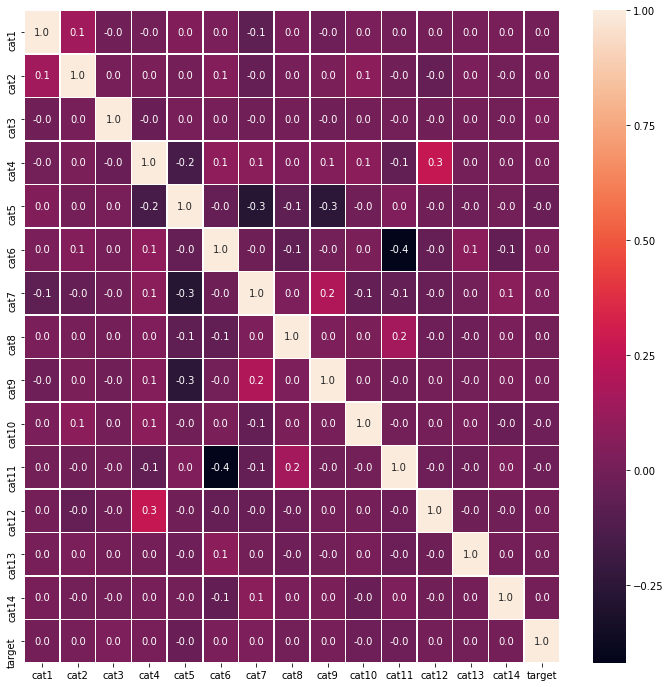

In [77]:
f,ax=plt.subplots(figsize=(12,12))
sns.heatmap(train[cat_cols].corr(),annot=True,linewidths=.5,fmt='.1f',ax=ax)

* Features num18,num20,num21,num22 have higher correlation with Target value

<Figure size 720x576 with 0 Axes>

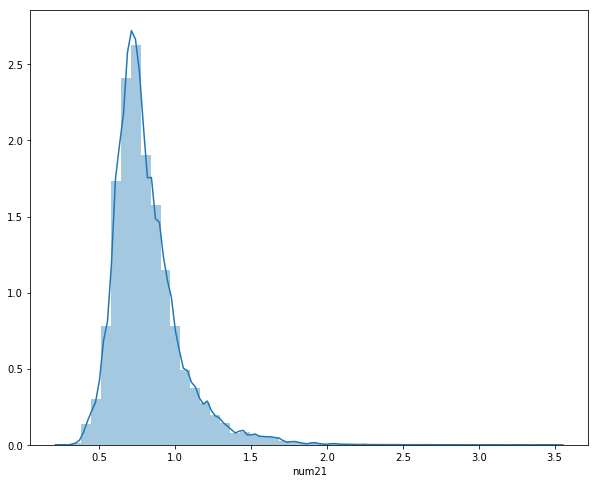

In [78]:
plt.figure(figsize=(10, 8))
train_1= train[train['target']==0]
sns.distplot(train_1['num21'], kde=True, hist=True, norm_hist=True)

In [79]:
# train[train['cat14'] == 104].shape
train[train['num22'] <= 0.28].shape

(906, 58)

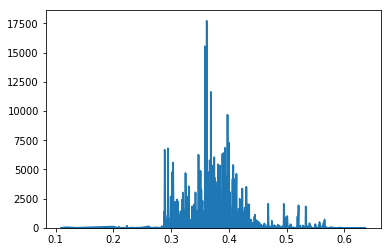

In [80]:
# train.iloc[:,:1]
train['num22'].value_counts().sort_index().plot.area()
# sns.countplot(train['num21'])

In [81]:
test[test['num21']>3.0].shape
train[train['num21']>3.0].groupby(['target'])['target'].count()

(17, 57)

target
0    12
1     1
Name: target, dtype: int64

In [82]:
train[train['num22'] < 0.28].groupby(['target'])['target'].count()

target
0    854
1     52
Name: target, dtype: int64

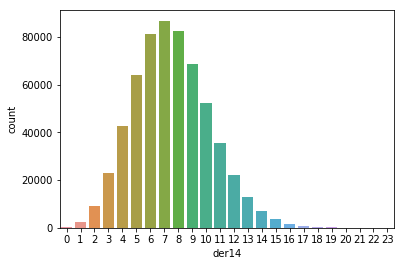

In [83]:
# train['target'].value_counts().sort_index().plot.bar()
# train['num2'].value_counts().plot.area()
sns.countplot(train['der14'])

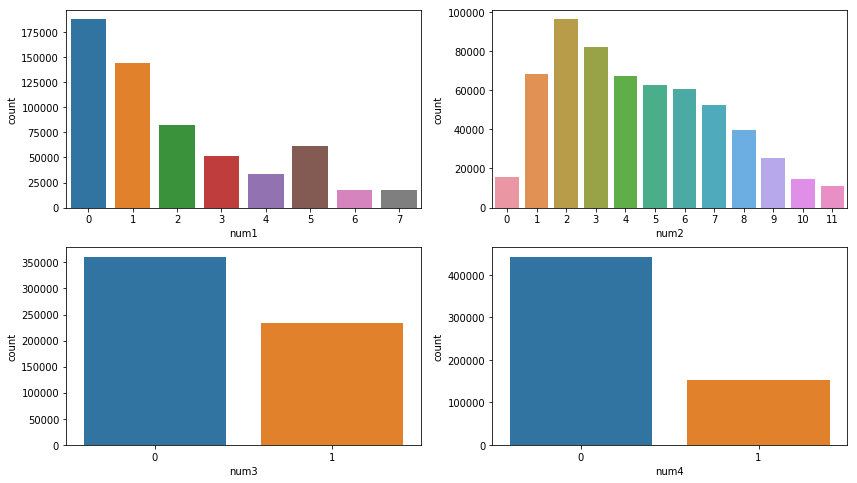

In [84]:
##can assign the each chart to one axes at a time
fig,axrr=plt.subplots(2,2,figsize=(14,8))

sns.countplot(train['num1'],ax=axrr[0][0])
sns.countplot(train['num2'],ax=axrr[0][1])
sns.countplot(train['num3'],ax=axrr[1][0])
sns.countplot(train['num4'],ax=axrr[1][1])

<a id ='section4'></a>

### Feature Generation by Feature Interaction

In [85]:
col = ['id', 'num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8','num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16',
       'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'der1','der2', 'der3', 'der4', 'der5', 'der6', 'der7', 'der8', 'der9', 'der10',
       'der11', 'der12', 'der13', 'der14', 'der15', 'der16', 'der17', 'der18','der19', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14']

* These Features have num18,num20,num21,num22,cat14 higher importance As we find latter in the Notebook

In [86]:
train['sum_zero'] = (train[col] == 0).sum(axis=1)
test['sum_zero'] = (test[col] == 0).sum(axis=1)

train['num18m21'] = train['num18'] * train['num21']
test['num18m21'] = test['num18'] * test['num21']
train['num18a21'] = train['num18'] + train['num21']
test['num18a21'] = test['num18'] + test['num21']

In [87]:
##Replace all Nan by Mode
for i in train.columns:
    train[i].fillna(train[i].mode()[0], inplace=True)
for i in test.columns:
    test[i].fillna(test[i].mode()[0], inplace=True)

* Split the data into train_id, train, target & test_id, test

In [88]:
Y1=train['target']
# train1=train.drop(['employee_id','is_promoted'],axis=1)
train1=train.drop(['id','target'],axis=1)
# train1=train.drop(['id','num7','num8','num9','num10','num11','cat10','cat13','target'],axis=1)
train1=train1
Y=Y1.values

test_id=test['id']
# test1 = test.drop(['employee_id'],axis=1)
# test1 = test.drop(['id','num7','num8','num9','num10','num11','cat10','cat13'],axis=1)
test1 = test.drop(['id'],axis=1)
test1=test1

<a id ='section5'></a>

### Generic Methods
* Function to plot the area under the curve (AUC) for a model & Plotting false positive rate and true positive rate
* Model evaluation Methods for classification_report

In [14]:
## This is a generic function to plot the area under the curve (AUC) for a model
def plot_auc(y_test,y_pred):
    fp_rate, tp_rate, treshold = roc_curve(y_test, y_pred)
    auc_score = auc(fp_rate, tp_rate)
    plt.figure()
    plt.title('ROC Curve')
    plt.plot(fp_rate, tp_rate, 'b', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [15]:
def evaluate_model(model, X_test_param, y_test_param):
    print("Model evaluation")
#     X_test_param, X_test, y_test_param, y_test = train_test_split(X_test_param, y_test_param, random_state=42,test_size=0.1)
#     model.fit(X_test_param, y_test_param,eval_set=[(X_test, y_test)],early_stopping_rounds=50,verbose=50)
    model.fit(X_test_param, y_test_param)
    y_pred = model.predict_proba(X_test_param)[:, 1]
    print("Accuracy: {:.5f}".format(model.score(X_test_param, y_test_param)))
    print("AUC: {:.5f}".format(roc_auc_score(y_test_param, y_pred)))
    print("\n#### Classification Report ####\n")
    
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc = np.array([f1_score(y_test_param, y_pred>thr) for thr in thresholds])
    best_threshold = thresholds[mcc.argmax()]
    predictions = list(map(lambda x: 1 if x > best_threshold else 0,y_pred))
    print(classification_report(y_test_param, predictions, target_names=['0','1']))
    plot_auc(y_test_param, y_pred )

In [16]:
train1.shape
test1.shape
Y.shape

(595212, 59)

(892816, 59)

(595212,)

<a id ='section6'></a>

### Plot Class Distribution

* Scale before applying PCA or Linear regression

In [89]:
scaler = StandardScaler()
# scaler = QuantileTransformer(n_quantiles=10, random_state=0)
scaler.fit(train1)
# Apply transform to both the training set and the test set.
train2 = scaler.transform(train1)
test2 = scaler.transform(test1)

StandardScaler(copy=True, with_mean=True, with_std=True)

> PCA to find the overlap between the decision boundaries of 1 and 0

,principal component 1,principal component 2,target
0,0.560460,0.564783,0
1,-0.896903,0.303693,0
2,-1.848676,-1.572082,0
3,-2.937133,-0.097048,0
4,-1.487695,-1.453341,0


Text(0.5,0,'Principal Component 1')

Text(0,0.5,'Principal Component 2')

Text(0.5,1,'2 Component PCA')

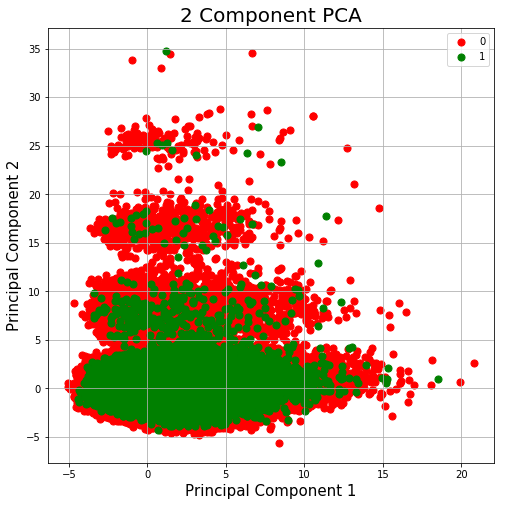

In [90]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train2)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, train['target']], axis = 1)
finalDf.head(5)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

> Decision Boundary between 0 and 1 are overlapping in two dimensions.So Linear model will not perform well

<a id ='section7'></a>

### Model Evaluation & Cross Validation

Model evaluation
Accuracy: 0.96358
AUC: 0.69556

#### Classification Report ####

             precision    recall  f1-score   support

          0       0.97      0.95      0.96    574284
          1       0.15      0.23      0.18     21716

avg / total       0.94      0.92      0.93    596000



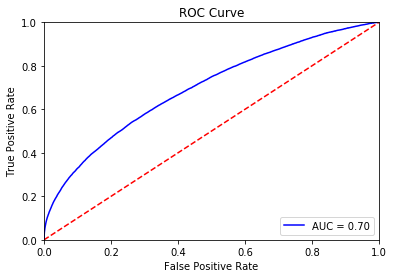

In [91]:
clf = lgb.LGBMClassifier()
# clf = LogisticRegression()
evaluate_model(clf, train1.values, Y)

In [35]:
#create the cross validation fold for different boosting and linear model.
from sklearn.cross_validation import StratifiedKFold
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
SEED=42
st_train = train1.values
st_test = test1.values
clf1 = xgb.XGBClassifier()
clf2 = lgb.LGBMClassifier(max_depth= 8, learning_rate=0.0941, n_estimators=197, num_leaves= 17, reg_alpha=3.4492 , reg_lambda= 0.0422) #lgb_pca
clf = ensemble.VotingClassifier(estimators = [('clf1', clf1),('clf2', clf2)],
                                       voting = 'soft', weights = [3,3])

fold = 3
cv = StratifiedKFold(Y, n_folds=fold,shuffle=True, random_state=30)
X_preds = np.zeros(st_train.shape[0])
preds = np.zeros(st_test.shape[0])
for i, (tr, ts) in enumerate(cv):
    print(ts.shape)
    mod = clf.fit(st_train[tr], Y[tr])
    X_preds[ts] = mod.predict_proba(st_train[ts])[:,1]
    preds += mod.predict_proba(st_test)[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(Y[ts], X_preds[ts])))
score = roc_auc_score(Y, X_preds)
print(score)
preds1 = preds/fold

(198405,)
fold 0, ROC AUC: 0.636
(198404,)
fold 1, ROC AUC: 0.643
(198403,)
fold 2, ROC AUC: 0.636
0.6382320382113563


> Ensemble of Xgboost and Lightgbm using VotingClassifier gave Cross validation cv of 64%

In [36]:
sub = pd.DataFrame({'id': test_id, 'target': preds1})
sub=sub.reindex(columns=["id","target"])
sub.to_csv('sub_vot.csv', index=False)

sub_oof = pd.DataFrame({'id': train['id'], 'target': X_preds})
sub_oof=sub_oof.reindex(columns=["id","target"])
sub_oof.to_csv('sub_oof_vot.csv', index=False)

In [ ]:
#lgb.plot_importance(clf,figsize=(20,10))

<a id ='section8'></a>

### Feature importance

In [92]:
rf = RandomForestClassifier()
rf.fit(train1,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

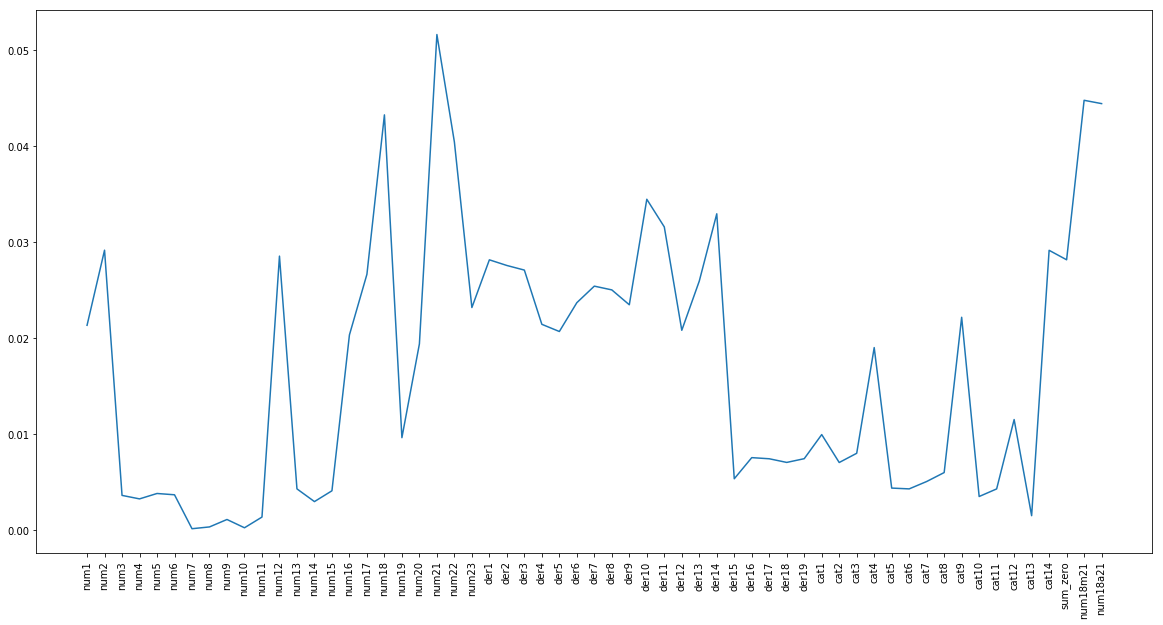

In [93]:
plt.figure(figsize=(20,10))
plt.plot(rf.feature_importances_)

plt.xticks(np.arange(train1.shape[1]), train1.columns.tolist(), rotation=90);

>Permutation Feature Importance

>RandomForest Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
train_X, val_X, train_y, val_y = train_test_split(train1[:100000], Y[:100000], random_state=1)
first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X, train_y)

#Make a small change to the code below to use in this problem. 
perm = PermutationImportance(rf, random_state=1).fit(val_X, val_y)

#uncomment the following line to visualize your results
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

<a id ='section9'></a>

### Train Test Distribution
To check Whether the Train and test have same Distribution or not

In [ ]:
#making copy
trn =  train.copy()
tst =  test.copy()

In [ ]:
tst['is_train'] = 0
trn['is_train'] = 1 #1 for train

In [ ]:
#combining test and train data
df_combine = pd.concat([trn, tst], axis=0, ignore_index=True)
#dropping 'target' column as it is not present in the test
df_combine = df_combine.drop('target', axis=1)

In [ ]:
y = df_combine['is_train'].values #labels
x = df_combine.drop('is_train', axis=1).values #covariates or our dependent variables

In [ ]:
scaler = StandardScaler()
# scaler = QuantileTransformer(n_quantiles=10, random_state=0)
scaler.fit(x)
# Apply transform to both the training set and the test set.
train2 = scaler.transform(x)
# test2 = scaler.transform(test1)

<a id ='section10'></a>

### Plot Class Distribution

>Other than the use of Predictive Model to find Distribution similarity.

>Can also use PCA for Finding Overlapping train and test sets on 2 dimensions

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train2)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_combine['is_train']], axis = 1)
finalDf.head(5)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_train'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

> Both Train Test have Same distribution.So,Results on train set will be equal to test set

<a id ='section11'></a>

### UnSupervised Feature Interaction

In [19]:
df_train = train.copy()
df_test = test.copy()
train_target = train['target'].values
ntrain = df_train.shape[0]
ntest  = df_test.shape[0]

In [20]:
from scipy.special import erfinv
def hot_encoder(df, columns):
    one_hot = {c: list(df[c].unique()) for c in columns}
    for c in one_hot:
        for val in one_hot[c]:
            df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

def scale_feat(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def rank_gauss(x):
    # x is numpy vector
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2 # rank_x.max(), rank_x.min() should be in (-1, 1)
    efi_x = erfinv(rank_x) # np.sqrt(2)*erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

def df_inputSwapNoise(df, p):
    ### feature with another value from the same column with probability p
    n = df.shape[0]
    idx = list(range(n))
    swap_n = round(n*p)
    for col in df.columns:
        arr = df[col].values
        col_vals = np.random.permutation(arr)
        swap_idx = np.random.choice(idx, size= swap_n)
        arr[swap_idx] = np.random.choice(col_vals, size = swap_n)
        df[col] = arr
    return df

In [21]:
print('Transforming data')
feature_cols = [c for c in df_train.columns if c not in ['id','target']]
keep_cols    = [c for c in feature_cols]
#scale_cols = ['num18','num20','num21','num22','cat14']
#keep_cols    = [c for c in feature_cols if c not in scale_cols] 
#cat_cols     = [c for c in keep_cols if '_cat' in c]
##num18,num20,num21,num22,cat14

df_all = pd.concat([df_train[keep_cols], df_test[keep_cols]])
#df_all = scale_feat(df_all)
df_all_org = df_all.copy()
df_all_noise = df_inputSwapNoise(df_all, 0.15)
#df_all = hot_encoder(df_all, keep_cols)
data_all_org = df_all_org.values
data_all_noise = df_all_noise.values
cols = data_all_org.shape[1]
#print(df_all.columns)
print('Final data with {} columns'.format(cols))

Transforming data
Final data with 59 columns


In [22]:
for i in range(cols):
    u = np.unique(data_all_org[:,i])
    if u.shape[0] > 3:
        data_all_org[:,i] = rank_gauss(data_all_org[:,i])

for i in range(cols):
    u = np.unique(data_all_noise[:,i])
    if u.shape[0] > 3:
        data_all_noise[:,i] = rank_gauss(data_all_noise[:,i])

train_data_orig = data_all_org[0:ntrain,:]
test_data_orig  = data_all_org[ntrain:,:]
train_data_noise = data_all_noise[0:ntrain,:]
test_data_noise  = data_all_noise[ntrain:,:]
print(train_data_orig.shape)
print(test_data_orig.shape)
print(train_data_noise.shape)
print(test_data_noise.shape)

(595212, 59)
(892816, 59)
(595212, 59)
(892816, 59)


In [23]:
print('Original data')
all_data = np.vstack((train_data_orig, test_data_orig))
print('Noise data')
all_data_noise = np.vstack((train_data_noise, test_data_noise))

Original data
Noise data


In [24]:
print('Creating neural net')
model = Sequential()
model.add(Dense(units=1500, input_dim = all_data.shape[1], kernel_initializer=glorot_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(units=1500, kernel_initializer=glorot_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(units=1500, kernel_initializer=glorot_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(all_data.shape[1])) 
model.add(Activation('linear'))

opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='mse', optimizer=opt)

Creating neural net


In [25]:
print('Training neural net')
epochs = 5
chck = ModelCheckpoint('keras_dae.h5', monitor='loss', save_best_only=True)
cb = [ EarlyStopping(monitor='loss', patience=100, verbose=2, min_delta=0), chck ]
model.fit(all_data_noise, all_data, batch_size=128, verbose=1, epochs=epochs, callbacks=cb)

print('Applying neural net')
train_data_transform = model.predict(train_data_orig)
test_data_transform = model.predict(test_data_orig)
print(train_data_transform.shape)
print(test_data_transform.shape)

Training neural net
Epoch 1/5
1488028/1488028 [==============================] - 185s 125us/step - loss: 0.1083
Epoch 2/5
1488028/1488028 [==============================] - 183s 123us/step - loss: 0.0863
Epoch 3/5
1488028/1488028 [==============================] - 183s 123us/step - loss: 0.0819
Epoch 4/5
1488028/1488028 [==============================] - 183s 123us/step - loss: 0.0798
Epoch 5/5
1488028/1488028 [==============================] - 183s 123us/step - loss: 0.0785


Applying neural net
(595212, 59)
(892816, 59)


In [26]:
train_data_transform.shape
test_data_transform.shape

(595212, 59)

(892816, 59)

<a id ='section12'></a>

### Modelling on Dae Data

In [ ]:
clf = lgb.LGBMClassifier()
# clf = lgb.LGBMClassifier(objective = 'binary',metric='binary_logloss',max_depth= 8, learning_rate=0.0941, n_estimators=197, num_leaves= 17, reg_alpha=3.4492 , reg_lambda= 0.0422)
evaluate_model(clf, train_data_transform, train_target)

In [27]:
#create the cross validation fold for different boosting and linear model.
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
SEED=42
st_train = train_data_transform
st_test = test_data_transform
Y = train_target
clf1 = xgb.XGBClassifier()
clf2 = lgb.LGBMClassifier(max_depth= 8, learning_rate=0.0941, n_estimators=197, num_leaves= 17, reg_alpha=3.4492 , reg_lambda= 0.0422) #lgb_pca
clf = ensemble.VotingClassifier(estimators = [('clf1', clf1),('clf2', clf2)],
                                       voting = 'soft', weights = [3,3])

fold = 3
cv = StratifiedKFold(Y, n_folds=fold,shuffle=True, random_state=30)
X_preds = np.zeros(st_train.shape[0])
preds = np.zeros(st_test.shape[0])
for i, (tr, ts) in enumerate(cv):
    print(ts.shape)
    mod = clf.fit(st_train[tr], Y[tr])
    X_preds[ts] = mod.predict_proba(st_train[ts])[:,1]
    preds += mod.predict_proba(st_test)[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(Y[ts], X_preds[ts])))
score = roc_auc_score(Y, X_preds)
print(score)
preds1 = preds/fold

(198405,)
fold 0, ROC AUC: 0.631
(198404,)
fold 1, ROC AUC: 0.636
(198403,)
fold 2, ROC AUC: 0.629
0.6317488511343456


In [34]:
sub1 = pd.DataFrame({'id': test_id, 'target': preds1})
sub1=sub1.reindex(columns=["id","target"])
sub1.to_csv('sub_dae.csv', index=False)

sub1_oof = pd.DataFrame({'id': train['id'], 'target': X_preds})
sub1_oof=sub1_oof.reindex(columns=["id","target"])
sub1_oof.to_csv('sub_oof_dae.csv', index=False)

### Weighted Average

In [45]:
targ = 0.65 * sub_oof['target'] + 0.35 * sub1_oof['target']
targ1 = 0.65 * sub['target'] + 0.35 * sub1['target']

In [44]:
roc_auc_score(Y, targ.values)

0.6379401234597274

In [46]:
subfin = pd.DataFrame({'id': test_id, 'target': targ1})
subfin=subfin.reindex(columns=["id","target"])
subfin.to_csv('sub_final.csv', index=False)

<a id ='section13'></a>

### LightGbm Model Tuning

In [ ]:
#lightgbm bayesian optimization
from sklearn.cross_validation import cross_val_score
from bayes_opt import BayesianOptimization

def xgboostcv(max_depth,learning_rate,n_estimators,num_leaves,reg_alpha,reg_lambda):
    return cross_val_score(lgb.LGBMClassifier(max_depth=int(max_depth),learning_rate=learning_rate,n_estimators=int(n_estimators),
                                             silent=True,nthread=-1,num_leaves=int(num_leaves),reg_alpha=reg_alpha,
                                           reg_lambda=reg_lambda),train1,Y,"roc_auc",cv=3).mean()

xgboostBO = BayesianOptimization(xgboostcv,{'max_depth': (3, 10),'learning_rate': (0.001, 0.1),'n_estimators': (10, 1000),
                                  'num_leaves': (4,30),'reg_alpha': (1, 5),'reg_lambda': (0, 0.1)})
xgboostBO.maximize()
print('-'*53)
print('Final Results')
print('XGBOOST: %f' % xgboostBO.res['max']['max_val'])

<a id ='section14'></a>

### Discussion Questions Answers

Q.1:- Briefly describe the conceptual approach you chose! What are the trade-offs?
> First part of the choosen model is a gradient boosting ensemble model because decision boundary between two different classes are not Linearly separable.only Non-linear model will perform better in this case.VotingClassifier using two different Gradient Boosting packages (Xgboost,LightGbm) is the first part of the solution.
The second part is the same VotingClassifier with xgboost and lightgbm upon the dataset obtained from Denoising Auto Encoder which is chosen because the original train-test distribution is same and test set have more records then trainset.
The final solution is the weighted Average of both the models where weights were decided based upon Cross validation score of Traiset.
Trade-offs:- Have used only the Gradient Boosting models in the final submission this could cause higher correlation of models in the ensemble which can lead to overfitting the trainSet.

Q.2:- What's the model performance? What is the complexity? Where are the bottlenecks?
> Roc_Auc have choose to measure the model Performance.Accuracy can't be used because of Unbalanced class count in the dataset.So we are getting 64% Roc_Auc score for 3 fold cv for First model of Ensemble and 63% Accuracy on Second Model with weighted Average the Score went to 65%.
Because of Ensemble of 4 different predictive models It is difficult for the interpretability of the model.the Runtime also more than single model.


Q.3:- If you had more time, what improvements would you make, and in what order of priority?
> 1. More feature generation by feature interaction and removing the unuseful features by keeping the useful one.
2. Data Imputation by using predictive modelling instead of Mode.Features like num18 have higher feature importance but have lot of Null values.so,carefully filling these null values can result in accuracy increase.
3. Tune the Xgboost and Dae Models on different Parameter space.Running the Dae Network for More number of Epochs or changing the Network architecture can also help.
4. Doing Two Level Stacking with different and diverse Models.

### ****END****